# Predict Churn

The purpose of this notebook is to train model to predict clients which might churn.

## Assignment

- What insights can you provide the business based on the data?
- Please describe the process and tools that you utilized to ‘clean’ and analyze the data.
- Are there customer variables that are closely related to renewals or churn? 
- How would you communicate your findings to a business stakeholder responsible for driving retention?
- How would you visualize this data in a concise, easily consumable format?  Feel free to provide example view.
- Would you make a recommendation to the business based on this info?
- What additional information would you look for in order to expand your analysis?
- Any other items you would want to add?

## Model Experiments

- Logistic Regression
- Decision Trees
- MLP

## Questions to Answer

- Customer variables related to churn?
- Can we target which customers need attention before churn?
- How can we advance model & improve performance?

In [219]:
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import pandas as pd
import numpy as np

In [8]:
full_df = pd.read_csv('../data/cleaned_data.csv')

In [10]:
df = full_df[['userid', 'licenses', 'assigned_licenses', 'market', 'channel', 'total_meetings_30days', 
             'total_meetings_30to60days', 'meetingdays', 'total_participants', 'webcam_duration', 
              'audio_duration', 'years_active', 'renewal_amount_due_usd', 'Renew_Status'
             ]]

In [12]:
df.columns = ['userid', 'licenses', 'assigned_licenses', 'market', 'channel',
       'total_meetings_30days', 'total_meetings_30to60days', 'meetingdays',
       'total_participants', 'webcam_duration', 'audio_duration',
       'years_active', 'renewal_amount_due_usd', 'target']

## Process Features

In [7]:
def encode_categorical_field(features_df, field):
    """
    One hot encode categorical data
    Return label encoded values and corresponding encoding list for decoding
    """
    dummies = features_df[field].str.get_dummies()
    encoded_df = pd.concat([features_df, dummies], axis=1)
    encoded_fields = list(dummies.columns)

    return encoded_df, encoded_fields

#### Encode categorical data

In [13]:
encoded_df, encoded_markets = encode_categorical_field(df, 'market')

In [16]:
encoded_df, encoded_channels = encode_categorical_field(encoded_df, 'channel')

### Encode target

- churn: target = 1
- renew: target = 0

In [19]:
def encode_target(t):
    if t == 'CHURN':
        return 1
    else:
        return 0
    
encoded_df['target'] = encoded_df.target.apply(encode_target)

In [21]:
encoded_df.columns

Index(['userid', 'licenses', 'assigned_licenses', 'market', 'channel',
       'total_meetings_30days', 'total_meetings_30to60days', 'meetingdays',
       'total_participants', 'webcam_duration', 'audio_duration',
       'years_active', 'renewal_amount_due_usd', 'target', 'ENG EMEA',
       'NON ENG EMEA', 'ROW', 'offline', 'online'],
      dtype='object')

In [22]:
df = encoded_df[['userid', 'licenses', 'assigned_licenses',
       'total_meetings_30days', 'total_meetings_30to60days', 'meetingdays',
       'total_participants', 'webcam_duration', 'audio_duration',
       'years_active', 'renewal_amount_due_usd', 'ENG EMEA',
       'NON ENG EMEA', 'ROW', 'offline', 'online', 'target']]

In [23]:
df.head()

,userid,licenses,assigned_licenses,total_meetings_30days,total_meetings_30to60days,meetingdays,total_participants,webcam_duration,audio_duration,years_active,renewal_amount_due_usd,ENG EMEA,NON ENG EMEA,ROW,offline,online,target
0,605751,20,52,620,364,31,386.0,368.00,52220.52,3.0,4800.0,0,0,1,1,0,0
1,616421,900,2235,5876,4201,31,3624.0,8150.00,453505.63,5.0,45900.0,0,0,1,1,0,1
2,601558,200,164,4758,2792,31,1246.0,82821.88,438716.33,7.0,17208.0,0,0,1,1,0,0
3,602314,50,46,161,137,31,152.0,0.00,14151.34,5.0,14490.0,0,0,1,1,0,0
4,602888,163,158,3291,1999,31,1957.0,78886.77,220080.08,6.0,24209.0,1,0,0,1,0,0


#### Drop missing columns

In [27]:
df = df.dropna()

### Normalise

In [99]:
def _min_max_norm(x_vals):
    min_x = min(x_vals)
    max_x = max(x_vals)
    diff = abs(min_x - max_x)
    normed = [(x - min_x)/diff for x in x_vals]
    return normed

In [122]:
df.iloc[0]

userid                       605751.000000
licenses                          0.000698
assigned_licenses                 0.002067
total_meetings_30days             0.005171
total_meetings_30to60days         0.003944
meetingdays                       1.000000
total_participants                0.004640
webcam_duration                   0.002616
audio_duration                    0.008039
years_active                      0.375000
renewal_amount_due_usd            0.005622
ENG EMEA                          0.000000
NON ENG EMEA                      0.000000
ROW                               1.000000
offline                           1.000000
online                            0.000000
target                            0.000000
Name: 0, dtype: float64

In [101]:
df['licenses'] = _min_max_norm(list(df.licenses))
df['assigned_licenses'] = _min_max_norm(list(df.assigned_licenses))
df['total_meetings_30days'] = _min_max_norm(list(df.total_meetings_30days))
df['total_meetings_30to60days'] = _min_max_norm(list(df.total_meetings_30to60days))
df['meetingdays'] = _min_max_norm(list(df.meetingdays))
df['total_participants'] = _min_max_norm(list(df.total_participants))
df['webcam_duration'] = _min_max_norm(list(df.webcam_duration))
df['audio_duration'] = _min_max_norm(list(df.audio_duration))
df['years_active'] = _min_max_norm(list(df.years_active))
df['webcam_duration'] = _min_max_norm(list(df.webcam_duration))
df['renewal_amount_due_usd'] = _min_max_norm(list(df.renewal_amount_due_usd))

In [175]:
df.to_csv('../data/normed_feature_data.csv', index=False)

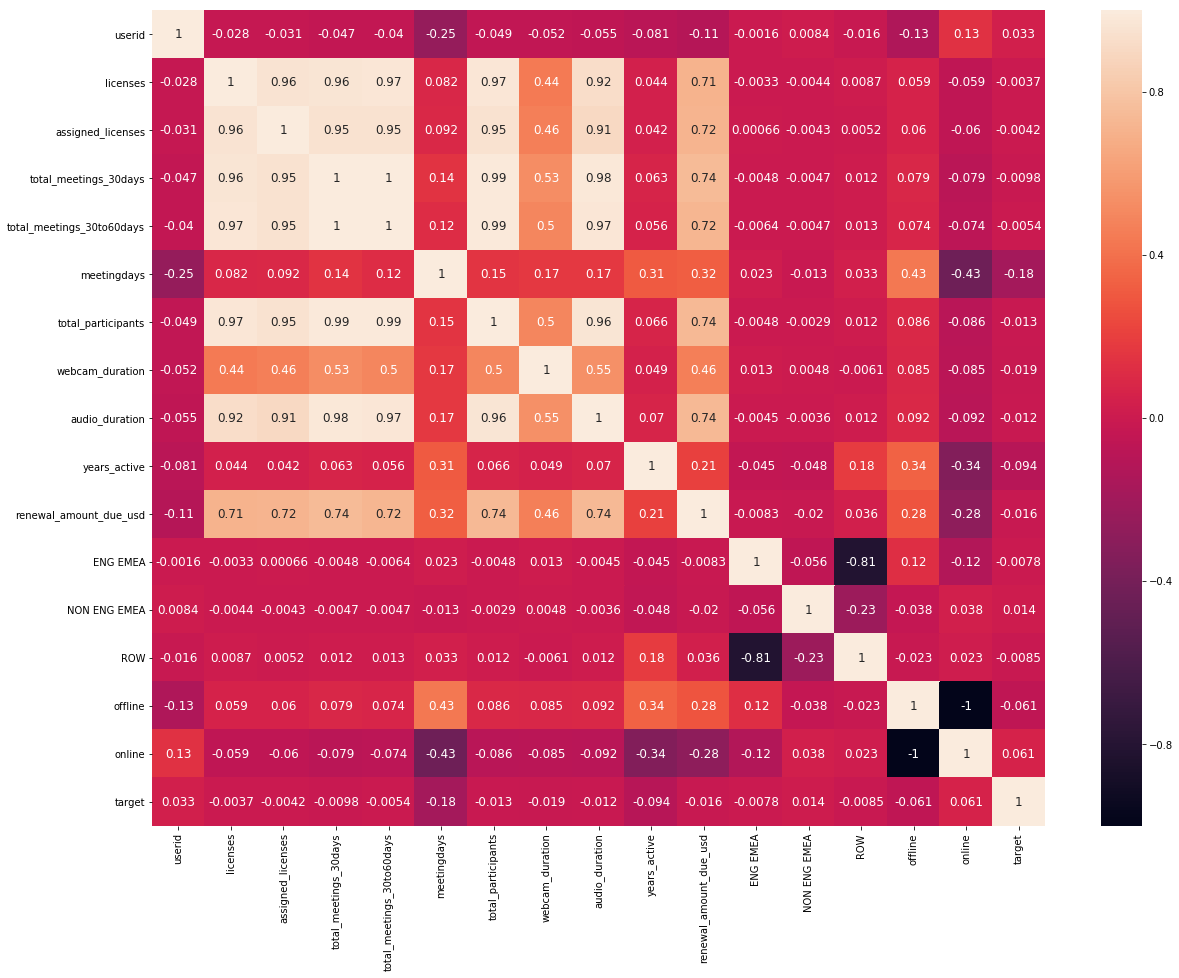

In [287]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Train/Test Split

In [288]:
# Shuffle
labelled_df = df.sample(frac=1).reset_index(drop=True)

target = np.ravel(labelled_df[['target']])

full_train_x, full_test_x, train_y, test_y = train_test_split(labelled_df, target, test_size=0.2)

FEATURES = ['licenses', 'assigned_licenses',
       'total_meetings_30days', 'total_meetings_30to60days',
       'total_participants', 'webcam_duration', 'audio_duration',
       'years_active', 'renewal_amount_due_usd', 'ENG EMEA',
       'NON ENG EMEA', 'ROW', 'offline', 'online']

train_x = full_train_x[FEATURES]
test_x = full_test_x[FEATURES]

print("Train X Shape: {}".format(train_x.shape))
print("Train Y Shape: {}".format(train_y.shape))
print("Test X Shape: {}".format(test_x.shape))
print("Test Y Shape: {}".format(test_y.shape))

Train X Shape: (46077, 14)
Train Y Shape: (46077,)
Test X Shape: (11520, 14)
Test Y Shape: (11520,)


## Balance Train Data

In [307]:
pos = full_train_x.loc[full_train_x.target == 1]
neg = full_train_x.loc[full_train_x.target == 0]

print("+ve train examples: {}".format(len(pos)))
print("-ve train examples: {}".format(len(neg)))

+ve train examples: 8721
-ve train examples: 37356


### Downsample Train

In [310]:
pos = full_train_x.loc[full_train_x.target == 1]
neg = full_train_x.loc[full_train_x.target == 0]

# shuffle and sample from neg
downsampled_neg = neg.sample(n=len(pos)).reset_index(drop=True)

# concat and shuffle
downsampled_train_x = pd.concat([pos, downsampled_neg])
downsampled_train_x = downsampled_train_x.sample(frac=1).reset_index(drop=True)

pos = downsampled_train_x.loc[downsampled_train_x.target == 1]
neg = downsampled_train_x.loc[downsampled_train_x.target == 0]

print("+ve train examples: {}".format(len(pos)))
print("-ve train examples: {}".format(len(neg)))

+ve train examples: 8721
-ve train examples: 8721


#### Infer downsampled train_y

In [319]:
downsampled_train_y = np.ravel(downsampled_train_x[['target']])
downsampled_train_x = downsampled_train_x[FEATURES]

print("Train X Shape: {}".format(downsampled_train_x.shape))
print("Train Y Shape: {}".format(downsampled_train_y.shape))
print("Test X Shape: {}".format(test_x.shape))
print("Test Y Shape: {}".format(test_y.shape))

Train X Shape: (17442, 14)
Train Y Shape: (17442,)
Test X Shape: (11520, 14)
Test Y Shape: (11520,)


### Upsample Train

In [317]:
data_majority = df[df['target']==0]
data_minority = df[df['target']==1]

pos = full_train_x.loc[full_train_x.target == 1]
neg = full_train_x.loc[full_train_x.target == 0]

# upsample from pos
upsampled_pos = resample(pos, replace=True, n_samples=len(neg), random_state=1) 

# concat and shuffle
upsampled_train_x = pd.concat([upsampled_pos, neg])
upsampled_train_x = upsampled_train_x.sample(frac=1).reset_index(drop=True)

pos = upsampled_train_x.loc[upsampled_train_x.target == 1]
neg = upsampled_train_x.loc[upsampled_train_x.target == 0]

print("+ve train examples: {}".format(len(pos)))
print("-ve train examples: {}".format(len(neg)))

+ve train examples: 37356
-ve train examples: 37356


##### Infer y vals

In [318]:
upsampled_train_y = np.ravel(upsampled_train_x[['target']])
upsampled_train_x = upsampled_train_x[FEATURES]

print("Train X Shape: {}".format(upsampled_train_x.shape))
print("Train Y Shape: {}".format(upsampled_train_y.shape))
print("Test X Shape: {}".format(test_x.shape))
print("Test Y Shape: {}".format(test_y.shape))

Train X Shape: (74712, 14)
Train Y Shape: (74712,)
Test X Shape: (11520, 14)
Test Y Shape: (11520,)


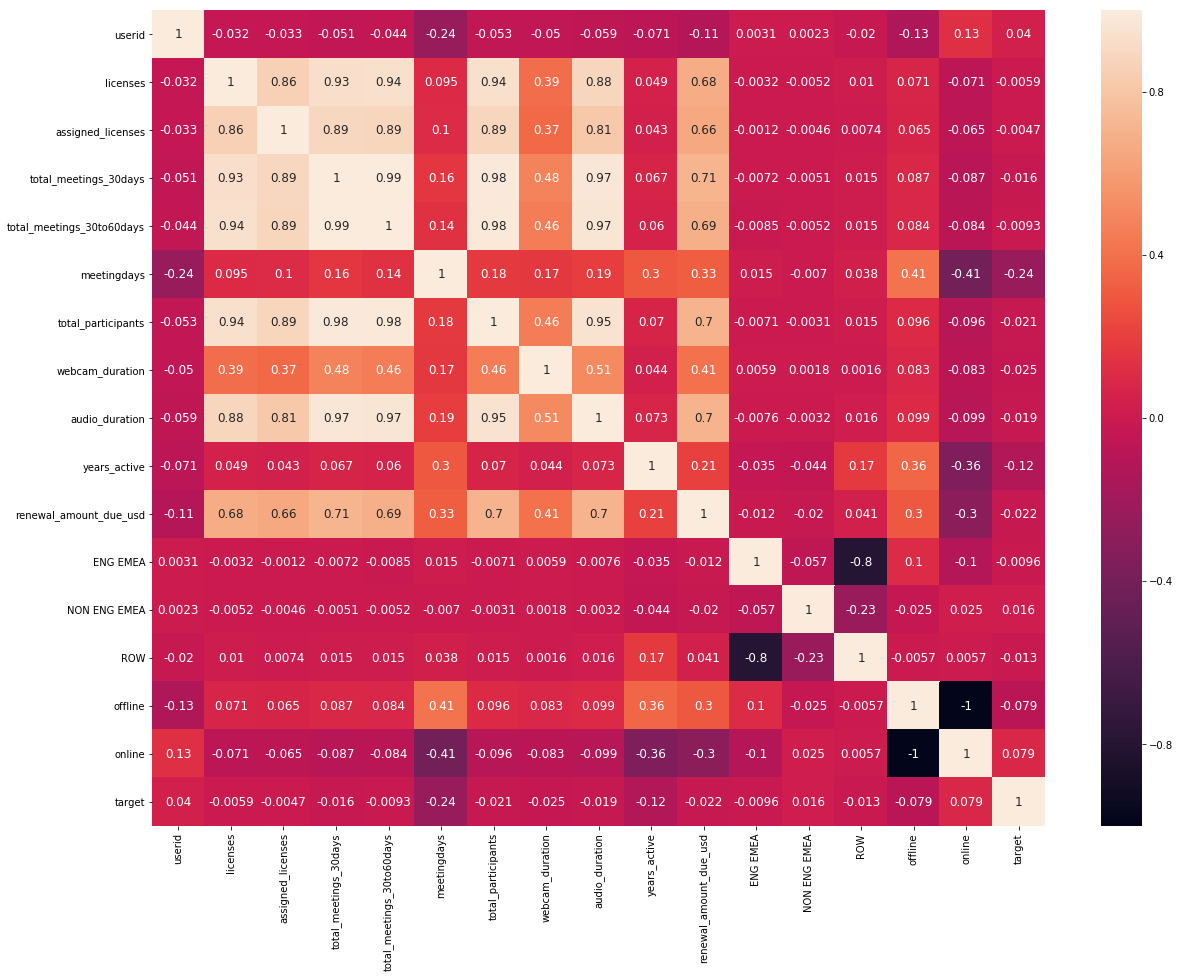

In [182]:
corr = data_upsampled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Train/Test Data

## Models

In [225]:
def evaluate(y_true, y_pred):
    print("Precision %s" % metrics.precision_score(y_true, y_pred))
    print("Recall %s" % metrics.recall_score(y_true, y_pred))
    print("F Score %s" % metrics.f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    confusion_matrix_df = pd.DataFrame(cm, ('Renew', 'Churn'), ('Renew', 'Churn'))
    heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
    plt.ylabel('Actual', fontsize = 14)
    plt.xlabel('Predicted', fontsize = 14)

### Logistic Regression

In [320]:
model = LogisticRegression()
model.fit(upsampled_train_x, upsampled_train_y)

print('Model Coeffs Shape: {}'.format(model.coef_.shape))

/Users/sdaly/.virtualenvs/lmi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Coeffs Shape: (1, 14)


#### Features in order of importance

In [321]:
importances = model.coef_[0]
order = np.argsort(importances)[::-1][:len(FEATURES)]
[FEATURES[i] for i in order]

['renewal_amount_due_usd',
 'assigned_licenses',
 'total_meetings_30to60days',
 'licenses',
 'NON ENG EMEA',
 'online',
 'ROW',
 'ENG EMEA',
 'offline',
 'total_meetings_30days',
 'audio_duration',
 'years_active',
 'total_participants',
 'webcam_duration']

Precision 0.22375397667020147
Recall 0.5861111111111111
F Score 0.3238679969301611
              precision    recall  f1-score   support

           0       0.85      0.53      0.65      9360
           1       0.22      0.59      0.32      2160

   micro avg       0.54      0.54      0.54     11520
   macro avg       0.54      0.56      0.49     11520
weighted avg       0.73      0.54      0.59     11520



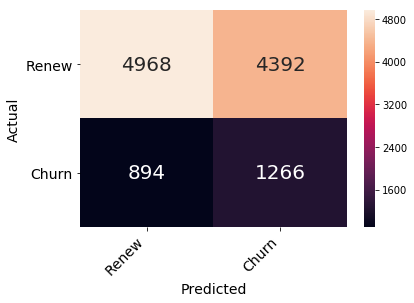

In [322]:
y_true = np.array(test_y)
y_pred = np.array(model.predict(test_x))

evaluate(y_true, y_pred)

In [323]:
model = LogisticRegression()
model.fit(downsampled_train_x, downsampled_train_y)

print('Model Coeffs Shape: {}'.format(model.coef_.shape))

Model Coeffs Shape: (1, 14)


/Users/sdaly/.virtualenvs/lmi/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [324]:
importances = model.coef_[0]
order = np.argsort(importances)[::-1][:len(FEATURES)]
[FEATURES[i] for i in order]

['renewal_amount_due_usd',
 'NON ENG EMEA',
 'total_meetings_30to60days',
 'ROW',
 'online',
 'assigned_licenses',
 'licenses',
 'ENG EMEA',
 'total_meetings_30days',
 'audio_duration',
 'offline',
 'total_participants',
 'years_active',
 'webcam_duration']

Precision 0.22723056946763123
Recall 0.5671296296296297
F Score 0.3244603363792875
              precision    recall  f1-score   support

           0       0.85      0.55      0.67      9360
           1       0.23      0.57      0.32      2160

   micro avg       0.56      0.56      0.56     11520
   macro avg       0.54      0.56      0.50     11520
weighted avg       0.73      0.56      0.61     11520



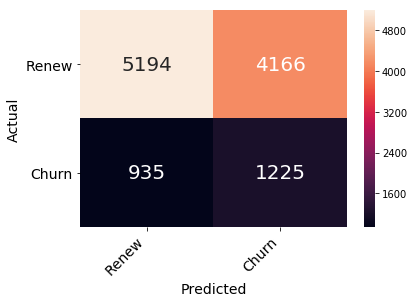

In [325]:
y_true = np.array(test_y)
y_pred = np.array(model.predict(test_x))

evaluate(y_true, y_pred)

## Decision Trees

In [326]:
model = DecisionTreeClassifier()
model.fit(upsampled_train_x, upsampled_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Features in order of importance

In [327]:
importances = model.feature_importances_
order = np.argsort(importances)[::-1][:len(FEATURES)]
[FEATURES[i] for i in order]

['total_meetings_30days',
 'audio_duration',
 'renewal_amount_due_usd',
 'total_participants',
 'webcam_duration',
 'years_active',
 'total_meetings_30to60days',
 'assigned_licenses',
 'licenses',
 'ENG EMEA',
 'ROW',
 'online',
 'offline',
 'NON ENG EMEA']

Precision 0.29673437901774236
Recall 0.5342592592592592
F Score 0.38155066953215405
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      9360
           1       0.30      0.53      0.38      2160

   micro avg       0.68      0.68      0.68     11520
   macro avg       0.58      0.62      0.58     11520
weighted avg       0.76      0.68      0.71     11520



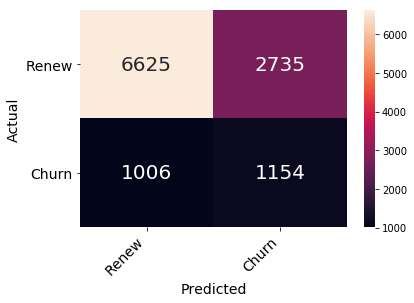

In [328]:
y_true = np.array(test_y)
y_pred = np.array(model.predict(test_x))

evaluate(y_true, y_pred)

In [329]:
model = DecisionTreeClassifier()
model.fit(downsampled_train_x, downsampled_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [330]:
importances = model.feature_importances_
order = np.argsort(importances)[::-1][:len(FEATURES)]
[FEATURES[i] for i in order]

['total_meetings_30days',
 'audio_duration',
 'renewal_amount_due_usd',
 'total_participants',
 'years_active',
 'webcam_duration',
 'total_meetings_30to60days',
 'assigned_licenses',
 'licenses',
 'ROW',
 'offline',
 'ENG EMEA',
 'online',
 'NON ENG EMEA']

Precision 0.24521972492452196
Recall 0.6768518518518518
F Score 0.36000984979069195
              precision    recall  f1-score   support

           0       0.87      0.52      0.65      9360
           1       0.25      0.68      0.36      2160

   micro avg       0.55      0.55      0.55     11520
   macro avg       0.56      0.60      0.51     11520
weighted avg       0.76      0.55      0.60     11520



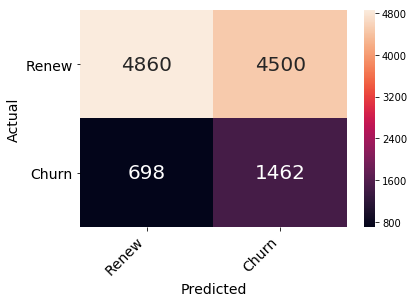

In [331]:
y_true = np.array(test_y)
y_pred = np.array(model.predict(test_x))

evaluate(y_true, y_pred)

## MLP

In [340]:
def train_mlp(train_x, train_y, verbose=True):
    """
    VERY basic multi layer perceptron neurel network
    Using keras only for POC
    """
    model = Sequential()

    model.add(Dense(32, activation='relu', kernel_initializer='normal', input_dim=train_x.shape[1]))
    model.add(Dense(64, activation='relu', kernel_initializer='normal'))
    model.add(Dense(64, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    if verbose:
        model.summary()
    model.fit(train_x, train_y, epochs=40, validation_split=.1)

    return model

In [341]:
model = train_mlp(upsampled_train_x, upsampled_train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 32)                480       
_________________________________________________________________
dense_111 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_112 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 33        
Total para

Precision 0.2630272952853598
Recall 0.7361111111111112
F Score 0.3875685557586837
              precision    recall  f1-score   support

           0       0.90      0.52      0.66      9360
           1       0.26      0.74      0.39      2160

   micro avg       0.56      0.56      0.56     11520
   macro avg       0.58      0.63      0.52     11520
weighted avg       0.78      0.56      0.61     11520



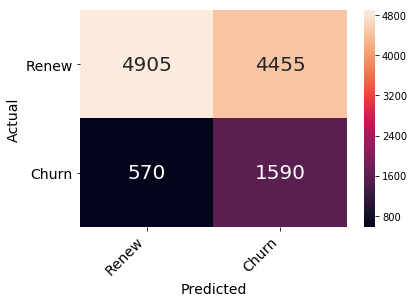

In [342]:
y_true = np.array(test_y)
y_pred = np.array([int(round(pred)) for pred in model.predict(test_x).flatten()])

evaluate(y_true, y_pred)

In [ ]:
tp + tn / TP + TN + FP + FN

In [350]:
(1590 + 4905) / (1590 + 4905 + 570 + 4455 )

0.5638020833333334

In [346]:
def train_mlp(train_x, train_y, verbose=True):
    """
    VERY basic multi layer perceptron neurel network
    Using keras only for POC
    """
    model = Sequential()

    model.add(Dense(32, activation='relu', kernel_initializer='normal', input_dim=train_x.shape[1]))
    model.add(Dense(64, activation='relu', kernel_initializer='normal'))
    model.add(Dense(64, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    if verbose:
        model.summary()
    model.fit(train_x, train_y, epochs=60, validation_split=.1)

    return model

In [335]:
model = train_mlp(downsampled_train_x, downsampled_train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 32)                480       
_________________________________________________________________
dense_102 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 33        
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________________________
Train on 15697 samples, validate on 1745 samples
Epoch 1/40
15697/15697 [==============================] - 4s 283us/step - loss: 0.6882 - ac

Precision 0.23222585642967808
Recall 0.624537037037037
F Score 0.33856192746894215
              precision    recall  f1-score   support

           0       0.86      0.52      0.65      9360
           1       0.23      0.62      0.34      2160

   micro avg       0.54      0.54      0.54     11520
   macro avg       0.55      0.57      0.49     11520
weighted avg       0.74      0.54      0.59     11520



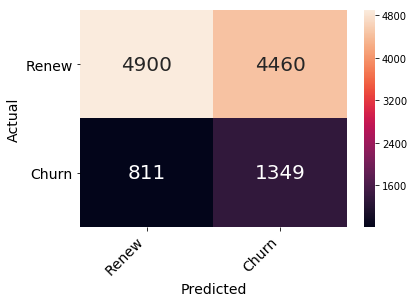

In [336]:
y_true = np.array(test_y)
y_pred = np.array([int(round(pred)) for pred in model.predict(test_x).flatten()])

evaluate(y_true, y_pred)

## Conclusion

- MLP shows most promising performance 
- More data needed!